In [7]:
### import libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

from math import sin, cos, sqrt, atan2, radians
from scipy import stats
from sklearn.neighbors import KDTree

import pickle
import glob, os

from datetime import datetime as dt
from datetime import timedelta
from datetime import timezone

from collections import Counter
from collections import OrderedDict

import pytz
import geopandas as gpd

### import data4resilience toolkit 
from d4r_toolkit import data_preprocess
from d4r_toolkit import mobanalytics
from d4r_toolkit import utils
from d4r_toolkit import POIvisit
from d4r_toolkit import viz

# Data import

## id list

In [8]:
idhome = "D:/WB_Mexico/results_eq/selectedids_homeloc.csv"
df_idhome = pd.read_csv(idhome,header=None, names=["id", "homelon","homelat"])
allids = set(df_idhome["id"].values)

## POI locations

In [9]:
shelterloc = pd.read_csv("D:/WB_Mexico/spatialdata/POIdata_new/POI_shelters.csv")
shelterloc.head()

,type,NOMBRE,LATITUD,LONGITUD,radius
0,shelter,Universidad del Valle de Mexico Campus San Angel,19.336474,-99.192650,100
1,shelter,Venustiano Carranza,19.419172,-99.112927,100
2,shelter,Azcapotzalco,19.483777,-99.184528,100
3,shelter,Universidad del Valle de Mexico Sede Coyoacan,19.311669,-99.138898,200
4,shelter,Universidad Nacional Autonoma de Mexico Casa U...,19.422911,-99.160724,100


In [10]:
Ps = shelterloc[["LATITUD","LONGITUD"]].values
tree = KDTree(Ps, leaf_size=30)

In [11]:
maxlat,minlat,maxlon,minlon = (max(shelterloc["LATITUD"])+0.01,min(shelterloc["LATITUD"])-0.01,
                               max(shelterloc["LONGITUD"])+0.01,min(shelterloc["LONGITUD"])-0.01)
bounds = [maxlat,minlat,maxlon,minlon]

# Estimate visit counts to POIs

In [12]:
picklepath = "D:/WB_Mexico/results_eq/poi_pickles/"
if not os.path.exists(picklepath):
    os.makedirs(picklepath)

In [ ]:
poifile = "D:/WB_Mexico/results_eq/POIvisit_estimate.csv"

In [ ]:
%%time
filenum=1
file_num = count_filenum(gpsroot)
for file in os.listdir(gpsroot):
    if file.endswith(".gz"):
        print("----",dt.now())
        POIvisit.get_poicount(gpsroot, file, bounds, shelterloc, df_idhome, outputpath)

In [ ]:
df_poi = POIvisit.collectresults_intodf(gpsroot,outputpath)

In [ ]:
# df_poi.to_csv(poifile)

# Visualize visit data

In [313]:
df_poi = pd.read_csv(poifile, header=0,sep=",",encoding="utf-8")
df_poi["date_dt"] = df_poi["date"].apply(lambda x : dt.strptime(str(x), '%Y%m%d %H'))

## trend analysis 

In [315]:
def get_trend_compare(df_poi, how, what):
    df_shelter = df_poi[df_poi[how]==what]
    shlter_agg = df_shelter.groupby("date_dt").sum().reset_index()
    shlter_agg["youbi_time"] = shlter_agg["date_dt"].apply(lambda x : str(x.weekday())+"_"+str(x.hour))
    shlter_agg_usual = shlter_agg.iloc[:14*24]
    shlter_agg_usual["youbi_time"] = shlter_agg_usual["date_dt"].apply(lambda x : str(x.weekday())+"_"+str(x.hour))
    shlter_agg_usual_avg = shlter_agg_usual.groupby('youbi_time').mean().reset_index()[["youbi_time","visits"]]
    shlter_agg_usual_sem = shlter_agg_usual.groupby('youbi_time').sem().reset_index()[["youbi_time","visits"]]
    avg_trend = shlter_agg_usual_avg.rename(columns={"visits": "avgtrend"})
    sem_trend = shlter_agg_usual_sem.rename(columns={"visits": "semtrend"})
    avg = shlter_agg.merge(avg_trend, on="youbi_time")
    avg = avg.merge(sem_trend, on="youbi_time")
    avg = avg.sort_values(by=['date_dt'])
    return avg

In [319]:
def plot_trend_compare(avg, how, what, showtrend, ax):
    if showtrend==True:
        trendmax = np.max(avg["avgtrend"])
        ax.plot(avg["date_dt"], avg["visits"]/trendmax, color="orange", label="data")
        ax.plot(avg["date_dt"], avg["avgtrend"]/trendmax, color="skyblue", label="trend")
        ax.fill_between(avg["date_dt"], 
                        (avg["avgtrend"]-avg["semtrend"])/trendmax, 
                        (avg["avgtrend"]+avg["semtrend"])/trendmax, 
                        color="skyblue", alpha=.5, label="trend (95% CI)")
        ax.annotate("Puebla Eq.", xy=("20170919 18:00:00", .9), 
                    fontsize=14, ha="left", color="red")
    else:
        ax.plot(avg["date_dt"], avg["visits"], color="orange", label="data")
        ax.annotate("Puebla Eq.", xy=("20170919 18:00:00", np.max(avg["visits"])*.9), 
                    fontsize=14, ha="left", color="red")
        
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    ax.set_xticks(["20170905","20170912","20170919","20170926","20171003","20171010"])
    ax.set_xlim("20170904 12:00:00","20171011")
    ax.set_ylim(0)
    ax.set_ylabel("Visit Index", fontsize=14)
    ax.axvline("20170919 13:00:00", color="red")
    if what == "shelter":
        what = "gathering locations"
    if how=="type":
        ax.set_title("POI type: "+what, fontsize=15, pad=10, weight='bold')
    elif how=="name":
        ax.set_title("POI name: "+what, fontsize=15, pad=10, weight='bold')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(fontsize=13, ncol=3, loc="upper left", bbox_to_anchor=(0,1.28))

## aggregate trends for all POI types

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


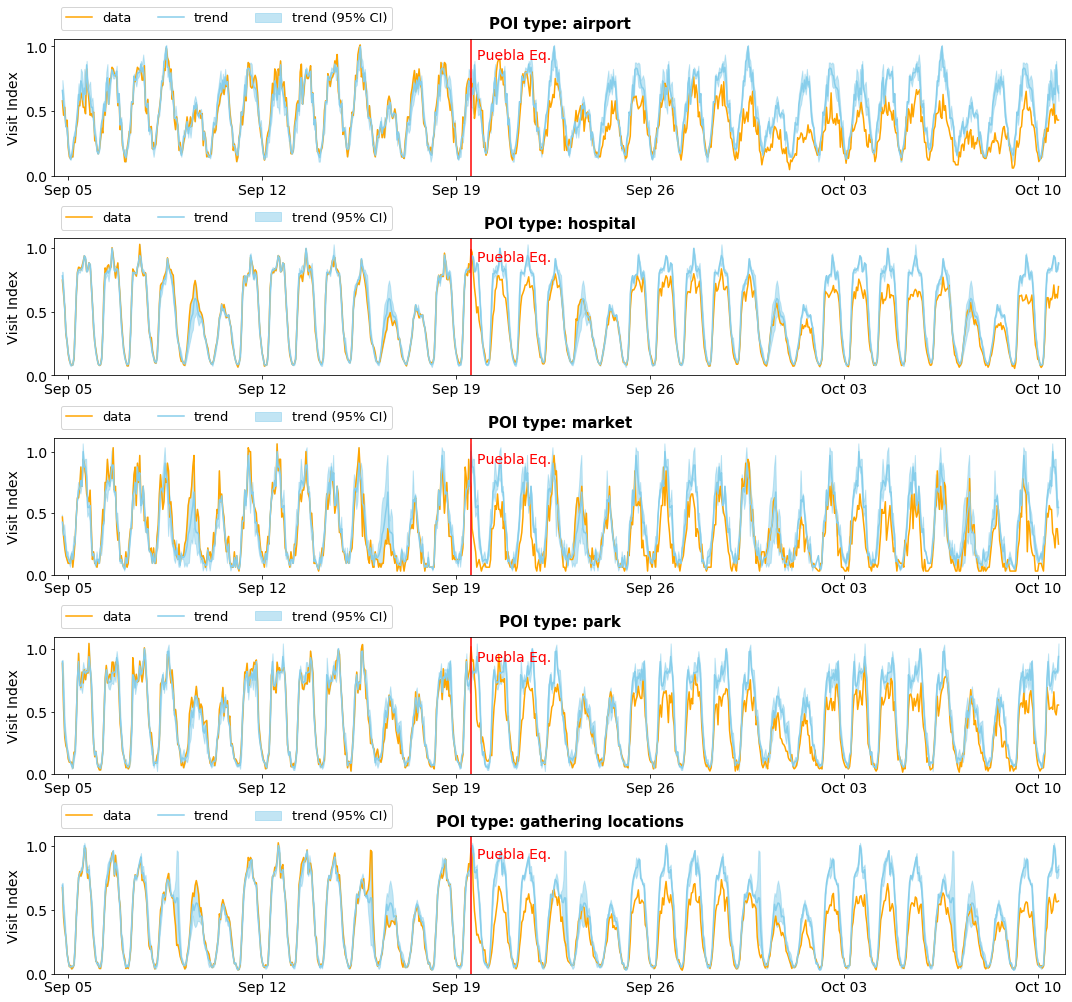

In [321]:
cats = ['airport', 'hospital', 'market', 'park', 'shelter']
how = "type"

fig=plt.figure(figsize=(15,2.8*len(cats)))
gs=GridSpec(len(cats),1)

for i,c in enumerate(cats):
    ax = fig.add_subplot(gs[i,0]) 
    avg = get_trend_compare(df_poi, how, c)
    plot_trend_compare(avg, how, c, True, ax)
            
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/visittrend_all.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## each POI for concerts

In [202]:
stadiums = set(df_poi[df_poi["type"]=="stadium"]["name"])

In [13]:
cats = stadiums
how = "name"

fig=plt.figure(figsize=(15,2.5*len(cats)))
gs=GridSpec(len(cats),1)

for i,c in enumerate(cats):
    ax = fig.add_subplot(gs[i,0]) 
    avg = get_trend_compare(df_poi, how, c)
    plot_trend_compare(avg, how, c, False, ax)
            
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/visittrend_all.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## Who came to shelter locations? 

In [208]:
shelters = set(df_poi[df_poi["type"]=="shelter"]["name"])

In [15]:
# shelters

In [14]:
cats = shelters
how = "name"

fig=plt.figure(figsize=(15,2.5*len(cats)))
gs=GridSpec(len(cats),1)

for i,c in enumerate(cats):
    ax = fig.add_subplot(gs[i,0]) 
    avg = get_trend_compare(df_poi, how, c)
    plot_trend_compare(avg, how, c, False, ax)
            
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/visittrend_all.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

# shelter catchment
## data

In [290]:
from scipy.stats import ttest_1samp
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

In [52]:
shelterloc = pd.read_csv("D:/WB_Mexico/spatialdata/POIdata_new/POI_shelters.csv")
shelterloc.head()

,type,NOMBRE,LATITUD,LONGITUD,radius
0,shelter,Universidad del Valle de Mexico Campus San Angel,19.336474,-99.192650,100
1,shelter,Venustiano Carranza,19.419172,-99.112927,100
2,shelter,Azcapotzalco,19.483777,-99.184528,100
3,shelter,Universidad del Valle de Mexico Sede Coyoacan,19.311669,-99.138898,200
4,shelter,Universidad Nacional Autonoma de Mexico Casa U...,19.422911,-99.160724,100


In [19]:
f = "D:/WB_Mexico/results_eq/POI_1128/POI_shelters.csv"
df_shel = pd.read_csv(f, sep="\t", header=None, 
                      names=["cat","name","capa","datetime","num","idlist"])
df_shel["date"] = df_shel["datetime"].apply(lambda x: str(x).split()[0])

In [ ]:
df_shel.head()

In [182]:
top = df_shel.groupby("name").sum().reset_index().sort_values("num", ascending=False)["name"].values
top

array(['Estadio Olimpico Universitario', 'Ciudad de Mexico',
       'Benito Juarez', 'Tecnologico de Monterrey Ciudad de Mexico',
       'Coyoacan', 'Universidad del Valle de Mexico Sede Coyoacan',
       'Cuauhtemoc', 'Universidad del Valle de Mexico Campus San Angel',
       'Universidad Nacional Autonoma de Mexico Casa Universitaria del Libro',
       'Universidad Autonoma Metropolitana Azcapotzalco',
       'Miguel Hidalgo',
       'Universidad del Valle de Mexico Campus San Rafael',
       'Venustiano Carranza', 'Alvaro Obregon',
       'Universidad La Salle Unidad Condesa', 'Azcapotzalco', 'Tlalpan',
       'Iztacalco', 'Gustavo A. Madero', 'Cuajimalpa de Morelos',
       'Iztapalapa', 'Escuela Nacional de Antropologia e Historia',
       'Tlahuac', 'Universidad Anahuac Mexico Campus Sur',
       'La Magdalena Contreras', 'Xochimilco',
       'Instituto Politecnico Nacional  ESCA Tepepan',
       'Universidad Autonoma Metropolitana Xochimilco (Auditorios)',
       'Instituto Poli

In [14]:
%store -r id_home_feat

In [ ]:
#### id - information
id_home_feat.head()

### computation

In [197]:
def getvisitinfo(shelter, date):
    befday = df_shel[df_shel["date"].isin(list(date))]
    befday_sub = befday[befday["name"]==shelter]
    allids = []
    for ids in befday_sub["idlist"]:
        for i in ids.split(","):
            if i!="":
                allids.append(i)
    allids_set = list(set(allids))
    ids_here = id_home_feat[id_home_feat["id"].isin(allids_set)]
    ids_here["distance"] = ids_here.apply(lambda row: distance(row["homelat"], row["homelon"], lat, lon), axis=1)
    return ids_here

In [213]:
date1 = ["20170912","20170913","20170914","20170915","20170916","20170917","20170918"]
date2 = ["20170919","20170920","20170921","20170922","20170923","20170924","20170925"]

variable = "distance"

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


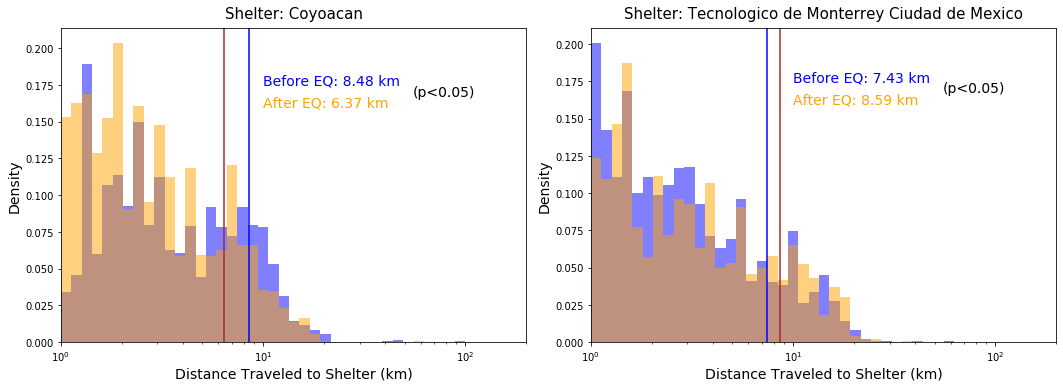

In [258]:
fig=plt.figure(figsize=(15,5.5))
gs=GridSpec(1,2)

i=0
for shelter in set(befday["name"]):
    latlon = shelterloc[shelterloc["NOMBRE"]==shelter][["LATITUD","LONGITUD"]]
    lat = latlon["LATITUD"].values[0]
    lon = latlon["LONGITUD"].values[0]
    bef = getvisitinfo(shelter,date1)
    aft = getvisitinfo(shelter,date2)

    maxdist = np.max((np.max(bef[variable].values),np.max(aft[variable].values)))
    res = stats.ttest_ind(bef[variable].values, aft[variable].values, equal_var = False)
    if res[1]<0.05:
        ax = fig.add_subplot(gs[0,i]) 
#         fig,ax = plt.subplots(figsize=(7,4))
        ax.hist(bef[variable].values,bins=np.logspace(0, int(np.log10(maxdist)), 40),
                density=True,alpha=.5, color="b")
        ax.axvline(np.mean(bef[variable].values), color="b")
        ax.hist(aft[variable].values,bins=np.logspace(0, int(np.log10(maxdist)), 40), 
                density=True,alpha=.5, color="orange")
        ax.axvline(np.mean(aft[variable].values), color="brown")
        ax.set_xlabel("Distance Traveled to Shelter (km)", fontsize=14)
        ax.set_xlim(1,200)
        ax.set_ylabel("Density", fontsize=14)
        ax.set_title("Shelter: "+shelter, fontsize=15, pad=10)
        ax.annotate("Before EQ: "+str(np.mean(bef[variable].values))[:4]+" km", 
                    xy=(10,0.175), color="b", fontsize=14)
        ax.annotate("After EQ: "+str(np.mean(aft[variable].values))[:4]+" km", 
                    xy=(10,0.16), color="orange", fontsize=14)
        ax.annotate("(p<0.05)", 
            xy=(55,0.1675), color="k", fontsize=14)

#         print(,np.std(bef[variable].values))
#         print(np.mean(aft[variable].values),np.std(aft[variable].values))
#         print("--")
        ax.set_xscale("log")
        i+=1
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/shelter_dist.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [299]:
variable = "index_pca"

def getshelters(variable):
    df = pd.DataFrame()
    for shelter in set(befday["name"]):
        latlon = shelterloc[shelterloc["NOMBRE"]==shelter][["LATITUD","LONGITUD"]]
        lat = latlon["LATITUD"].values[0]
        lon = latlon["LONGITUD"].values[0]
        bef = getvisitinfo(shelter,date1)
        aft = getvisitinfo(shelter,date2)
        dist = np.mean(aft[variable].values)
        df = df.append({"shelter":shelter, "dist":dist, "lon":lon, "lat":lat}, ignore_index=True)
    df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), 
                              crs= {"init": "epsg:4326"}).to_crs(epsg=3857)
    return df_gdf

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


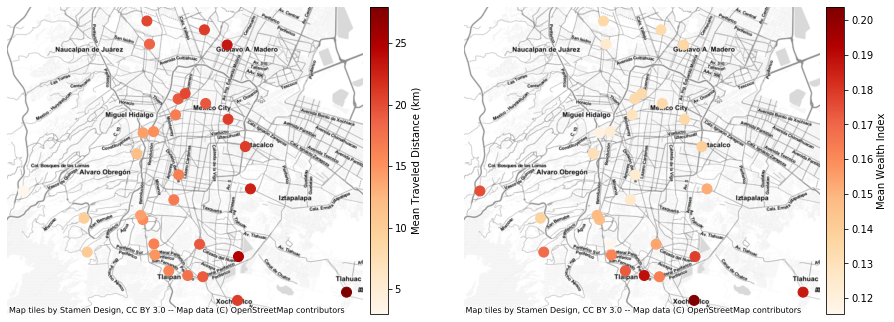

In [302]:
fig=plt.figure(figsize=(15,8))
gs=GridSpec(1,2)

ax = fig.add_subplot(gs[0,0]) 
divider = make_axes_locatable(ax)
df_gdf = getshelters("distance")
cax = divider.append_axes("right", size="5%", pad=0.1)
df_gdf.plot(ax=ax, column='dist', cmap='OrRd', legend=True, markersize=100, 
                    cax=cax, legend_kwds={'label': "Mean Traveled Distance (km)"}, alpha=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

ax2 = fig.add_subplot(gs[0,1]) 
divider = make_axes_locatable(ax2)
df_gdf = getshelters("index_pca")
cax = divider.append_axes("right", size="5%", pad=0.1)
df_gdf.plot(ax=ax2, column='dist', cmap='OrRd', legend=True, markersize=100, 
                    cax=cax, legend_kwds={'label': "Mean Wealth Index"}, alpha=1)
ctx.add_basemap(ax2, source=ctx.providers.Stamen.TonerLite)
ax2.set_axis_off()

# plt.savefig("C:/users/yabec/desktop/shelters_distance.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()